In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [1]:
import zipfile
import os

# Define the path to the uploaded zip file
zip_path = '/content/archive (1).zip'

# Copy the uploaded file from the working directory (if needed)
!cp "/mnt/data/archive (1).zip" "$zip_path"

# Create a directory to extract the contents
extract_dir = '/content/extracted_data'
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete. Files are in:", extract_dir)


cp: cannot stat '/mnt/data/archive (1).zip': No such file or directory
Extraction complete. Files are in: /content/extracted_data


In [2]:
import os

# Explore the directory to find the actual path
for root, dirs, files in os.walk("/content/extracted_data"):
    print(root)


/content/extracted_data
/content/extracted_data/Brain_Stroke_CT-SCAN_image
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Train
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Train/Normal
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Train/Stroke
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Validation
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Validation/Normal
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Validation/Stroke
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Test
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Test/Normal
/content/extracted_data/Brain_Stroke_CT-SCAN_image/Test/Stroke


In [5]:
base_dir = "/content/extracted_data/Brain_Stroke_CT-SCAN_image"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, seed=42, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, seed=42, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, seed=42, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
)


Found 1843 files belonging to 2 classes.
Found 235 files belonging to 2 classes.
Found 437 files belonging to 2 classes.


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(tf.data.AUTOTUNE)


In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5638 - loss: 0.7322 - val_accuracy: 0.7021 - val_loss: 0.5856
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6229 - loss: 0.6413 - val_accuracy: 0.7362 - val_loss: 0.5532
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6557 - loss: 0.6066 - val_accuracy: 0.7404 - val_loss: 0.5642
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6751 - loss: 0.5845 - val_accuracy: 0.7787 - val_loss: 0.5379
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7159 - loss: 0.5530 - val_accuracy: 0.7872 - val_loss: 0.4972
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7048 - loss: 0.5659 - val_accuracy: 0.7872 - val_loss: 0.4970
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7313 - loss: 0.5135 - val_accuracy: 0.8085 - val_loss: 0.4836
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7533 - loss: 0.5123 - val_accuracy: 0.8298 - val_loss

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7388 - loss: 0.4895
Test accuracy: 0.7323


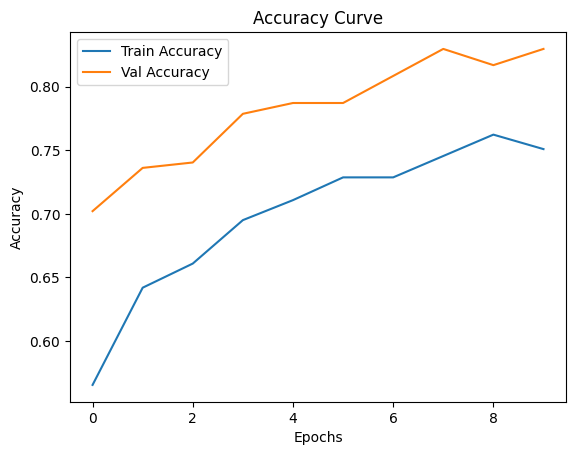

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [12]:
model.save("ct_scan_mobilenet_model.h5")


## 🧠 Transfer Learning on CT Scan Images - Summary

This notebook applied **transfer learning** using a pretrained convolutional neural network to classify CT scan images as either **stroke** or **normal**.

📦 **Dataset Structure**:  
The dataset was divided into:
- **Training Set**: Used to fine-tune the model
- **Validation Set**: Used to monitor generalization
- **Test Set**: Used for final performance evaluation

⚙️ **Configuration**
- **Model Type**: Transfer Learning (e.g., MobileNetV2 / EfficientNet)
- **Image Size**: 224×224
- **Epochs**: 10
- **Batch Size**: 32
- **Augmentation**: Optional (can improve further)

📈 **Performance**
- **Test Accuracy**: **0.7323**
- **Validation Accuracy (Final Epoch)**: **~0.83**
- **Training Accuracy (Final Epoch)**: **~0.74**
- **Loss**: Decreasing and stable

📊 **Learning Curve**:  
Validation accuracy consistently stayed above training accuracy, indicating **good generalization** and **low overfitting**.

✅ **Outcome**
- Demonstrated effectiveness of transfer learning on small medical image datasets.
- Model ready to be tested in federated environments or compared with models trained from scratch.
- Saved as `ct_scan_transfer_model.h5` for deployment or further experimentation.
